In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '331106',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/tQVVSXcmYLvAoI28cp-2Tg__thumb/img/ahKWaUSws5zja4feB4VexkNV3Mc=/fit-in/200x150/filters:strip_icc()/pic5974859.jpg',
  'name': 'The Witcher: Old World',
  'yearpublished': '2022'},
 {'id': '219650',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/OodUXfXjkiwGsHKRLjsloA__thumb/img/9UMSP_2fjLQzEQRsDPH_brSiVzY=/fit-in/200x150/filters:strip_icc()/pic3630071.jpg',
  'name': 'Arydia: The Paths We Dare Tread'}]

In [6]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 28)
page number = 20 (max: 100, len: 20)
page number = 30 (max: 100, len: 15)
page number = 40 (max: 100, len: 12)
page number = 50 (max: 100, len: 7)
page number = 60 (max: 100, len: 7)
page number = 70 (max: 100, len: 5)
page number = 80 (max: 100, len: 5)
page number = 90 (max: 100, len: 3)
page number = 100 (max: 100, len: 2)
page number = 110 (max: 100, len: 1)
page number = 120 (max: 100, len: 1)
page number = 130 (max: 100, len: 1)
page number = 140 (max: 100, len: 1)
comments_df shape: (122647, 4)


,id,username,rating,value
0,331106,aggers,N/A,Kickstarter
1,331106,Allethar,N/A,I played twice during testing phase - the vani...
2,331106,AndersBerg,N/A,Backed for 1€
3,331106,Angela_fba,N/A,Ks 2021 -> Jun 2022
4,331106,arnaud4matagot,9,tested online
...,...,...,...,...
122642,68448,_Dani_,N/A,My #1 on DSP 2011.
122643,68448,_mun_,9,A játékosok minden körben egyszerre cselekszen...
122644,68448,_teece_,7,Really enjoyable game and amazing that it stre...
122645,68448,_The_Inquiry_,6,Prior to 2020: 10 plays (est) 7 Wonders is ev...


## DATA CLEANING

In [7]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [8]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 19094 for 'remove_short_comments' - min len: 25 - method: unrated


In [9]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [10]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

9          18887
8          17992
10         17883
7          10404
N/A         7897
           ...  
8.95333        1
6.808          1
7.775          1
9.225          1
3.35           1
Name: rating, Length: 603, dtype: int64

In [11]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(95656, 5)

In [12]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(7897, 5)

## CREATE TRAINING AND VALIDATION DATA

In [13]:
# use rated comments (reviews) to train the model

In [14]:
rated_comments = rated_comments.sample(frac=1)

In [15]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [16]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


"Didn't really gel when I first attempted this game with my parents on the back of its spiel des Jahre success. Traded away after only a couple of plays.  I have played this again more reason and boosted th rating up to a 7. It is a neat card drafting game, and the potential for a higher player count makes it good for social situations. Will probably try and get a copy to add to my collection again"

In [17]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


"Started off extremely promising. The combat was fun, the world was fascinating, and then all these underlying problems I had with the game dominoe'd into just not being fun.  Even with house rules, I had no desire to go back."

## COMPOSE MODEL

In [18]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [19]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
47/47 - 4s - loss: 0.5711 - accuracy: 0.7795 - val_loss: 0.4912 - val_accuracy: 0.8503
Epoch 2/100
47/47 - 3s - loss: 0.4373 - accuracy: 0.8525 - val_loss: 0.3954 - val_accuracy: 0.8522
Epoch 3/100
47/47 - 3s - loss: 0.3542 - accuracy: 0.8600 - val_loss: 0.3453 - val_accuracy: 0.8659
Epoch 4/100
47/47 - 3s - loss: 0.3054 - accuracy: 0.8806 - val_loss: 0.3248 - val_accuracy: 0.8739
Epoch 5/100
47/47 - 3s - loss: 0.2734 - accuracy: 0.8934 - val_loss: 0.3176 - val_accuracy: 0.8768
Epoch 6/100
47/47 - 3s - loss: 0.2485 - accuracy: 0.9035 - val_loss: 0.3190 - val_accuracy: 0.8767
Epoch 7/100
47/47 - 3s - loss: 0.2275 - accuracy: 0.9124 - val_loss: 0.3224 - val_accuracy: 0.8763
Epoch 8/100
47/47 - 3s - loss: 0.2095 - accuracy: 0.9195 - val_loss: 0.3318 - val_accuracy: 0.8730
Epoch 9/100
47/47 - 2s - loss: 0.1937 - accuracy: 0.9271 - val_loss: 0.3434 - val_accuracy: 0.8678
Epoch 10/100
47/47 - 2s - loss: 0.1807 - accuracy: 0.9326 - val_loss: 0.3559 - val_accuracy: 0.8634
32/32 - 0

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000024992FD2EE0>,
             param_grid={})

In [20]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [21]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [23]:
epochs = range(1, len(acc) + 1) 

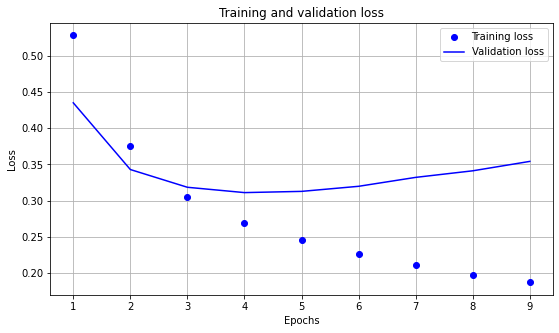

In [24]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

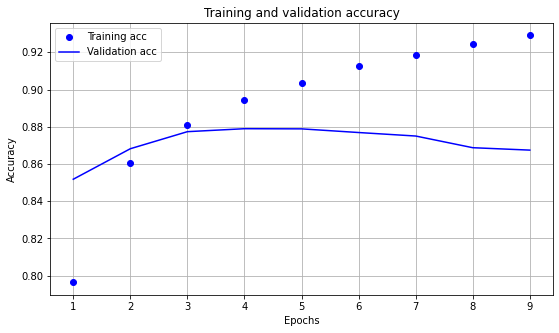

In [25]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [26]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"Didn't really gel when I first attempted this game with my parents on the back of its spiel des Jahre success. Traded away after only a couple of plays.  I have played this again more reason and boosted th rating up to a 7. It is a neat card drafting game, and the potential for a higher player count makes it good for social situations. Will probably try and get a copy to add to my collection again"
score: 1.000000
actual: 1

input:
"57 x 87 25 Cards 65 x 100 123 Cards "
score: 1.000000
actual: 1

input:
"Brass Birmingham is a meaty, thinky euro game that never ceases to impress. It is also one of the few games that feature both negative and positive interaction between players - or rather a form of cooperation in the business end of the game.  The rules aren't overtly difficult or convoluted, but you might want to hold off inviting your casual gamer friends to the table - at least until you can play the game well enough yourself. The core gameplay is pretty basic - two moves pe

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
## APPLY MODEL ON NON-RATED COMMENTS

In [28]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

8/8 - 0s
input:
"Want 3rd edition plus expansions & goodies (incl. Kickstarter bonuses)"
score: 1.000000

input:
"This is an awesome two-player game with a lot of replayability.  It's better balanced than the multi-player 7 Wonders."
score: 1.000000

input:
"Pro: - Campaign/Story Driven (15+ scenarios) - Cooperative or Solo - Card based + Artwork is great - Miniatures - Deck building/customization - Modular, Exploration sorta like 7th Continent  Want to play priority:  - 5 out of 5"
score: 1.000000

input:
"Seems like sth I would enjoy as hell but given my experience in GoT and FS this one would hit the table once in millennium. Will gladly try it but won't buy it."
score: 1.000000

input:
"2-player will be "quite confrontational""
score: 1.000000

input:
"1-5 players (4), Competitive ~90-115 mins ~24k HUF + expansions Complexity: 3.39"
score: 1.000000

input:
"Great! Love This unique game and strategy."
score: 1.000000

input:
"To be played in ~4 people to really enjoy it."
score: 1.0

## REGRESSOR

In [29]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x00000249A8D57F70>,
             param_grid={})

In [30]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [31]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [32]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [33]:
epochs = range(1, len(mean_squared_error) + 1) 

In [34]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.36


In [35]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 1.10


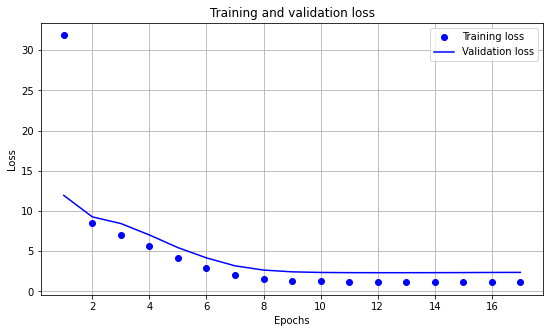

In [36]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

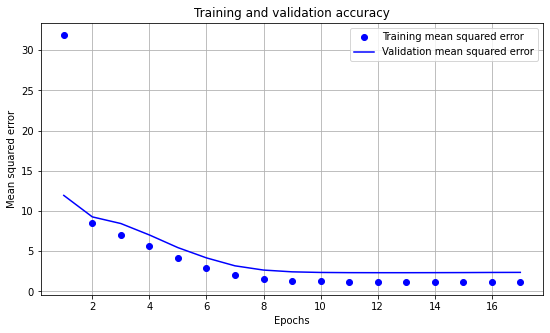

In [37]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [38]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"Didn't really gel when I first attempted this game with my parents on the back of its spiel des Jahre success. Traded away after only a couple of plays.  I have played this again more reason and boosted th rating up to a 7. It is a neat card drafting game, and the potential for a higher player count makes it good for social situations. Will probably try and get a copy to add to my collection again"
score: 7.10
actual: 7.50 

input: 
"57 x 87 25 Cards 65 x 100 123 Cards "
score: 8.26
actual: 7.00 

input: 
"Brass Birmingham is a meaty, thinky euro game that never ceases to impress. It is also one of the few games that feature both negative and positive interaction between players - or rather a form of cooperation in the business end of the game.  The rules aren't overtly difficult or convoluted, but you might want to hold off inviting your casual gamer friends to the table - at least until you can play the game well enough yourself. The core gameplay is pretty basic - two moves

## COMPARE CLASSIFIER VS REGRESSOR

In [39]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"Backed second run Kickstarter.  Preorder - Main Game - Solo Scenarios - Standees"
    reg score: 8.72
    clf score: 1

"Run away leader, Luck, and denial strategy issue."
    reg score: 6.01
    clf score: 1

"Uh, we're going to need a bigger boat..."
    reg score: 7.03
    clf score: 0

"I was having great expectations from this title, but it fell short on implementation.  I felt bored halfway through the first game, like my decisions didn't matter as much as luck from the draw."
    reg score: 5.78
    clf score: 0

"Captain America Ms. Marvel Green Goblin  "
    reg score: 6.28
    clf score: 1

"It's beautiful, it's thematic, the rules all make sense so it's dead-easy to explain and teach. But the game itself lacks the tension it would take to make it a standout game for us. It's a fun game, but I'd describe it as a light game wrapped in mid-weight processes."
    reg score: 7.68
    clf score: 1

"big box all promos and expansions except Rise"
    reg score: 9.32
    clf score:

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [40]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 120677 |          8.02 |           4869 |
| 124361 |          8.19 |           3856 |
| 162886 |          8.36 |           3534 |
| 167355 |          8.42 |           1826 |
| 167791 |          8.21 |           8269 |


In [41]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [42]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 120677 |          7.63 |            308 |
| 124361 |          7.94 |            255 |
| 162886 |          8.05 |            317 |
| 167355 |          8.22 |            215 |
| 167791 |          8.19 |            440 |


In [43]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [44]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/tQVVSXc...","<a href=""https://boardgamegeek.com/boardgame/3...",6.172581,8.644929,7.251424,1,2022
1,"<img src=""https://cf.geekdo-images.com/OodUXfX...","<a href=""https://boardgamegeek.com/boardgame/2...",7.500000,8.233315,8.023797,2,NaN
2,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.808941,7.761214,7.805091,3,2020
3,"<img src=""https://cf.geekdo-images.com/gTxav_K...","<a href=""https://boardgamegeek.com/boardgame/2...",7.818429,8.207936,7.955477,4,2021
4,"<img src=""https://cf.geekdo-images.com/PhjygpW...","<a href=""https://boardgamegeek.com/boardgame/3...",8.096540,7.813831,8.069239,5,2020


In [45]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [46]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,The Witcher: Old World,6.172581,8.644929,7.251424,1,2022
2,,Arydia: The Paths We Dare Tread,7.500000,8.233315,8.023797,2,NaN
3,,Lost Ruins of Arnak,7.808941,7.761214,7.805091,3,2020
4,,Oath: Chronicles of Empire and Exile,7.818429,8.207936,7.955477,4,2021
5,,Dune: Imperium,8.096540,7.813831,8.069239,5,2020


In [47]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Imperium: Classics,9.071429,7.886186,8.808041,22,2021
2,,Eclipse: Second Dawn for the Galaxy,8.722904,7.967863,8.606525,29,2020
3,,Brass: Birmingham,8.680774,8.173305,8.635074,25,2018
4,,Middara: Unintentional Malum – Act 1,8.648229,8.275028,8.561269,39,2019
5,,Gloomhaven: Jaws of the Lion,8.589068,8.041418,8.534621,23,2020


In [48]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Imperium: Classics,9.071429,7.886186,8.808041,22,2021
2,,Brass: Birmingham,8.680774,8.173305,8.635074,25,2018
3,,Eclipse: Second Dawn for the Galaxy,8.722904,7.967863,8.606525,29,2020
4,,Middara: Unintentional Malum – Act 1,8.648229,8.275028,8.561269,39,2019
5,,Gloomhaven: Jaws of the Lion,8.589068,8.041418,8.534621,23,2020


In [49]:
# model.save('saved_model\my_model')

In [50]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [51]:
# some examples on "long" comments vs short comments

In [52]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [53]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"Prio.: 1 3. Platz Deutscher Spielepreis (2014) Finalist  International Gamers Award (2014) Mehrspieler 1. Platz Nederlandse Spellenprijs (2015) Spiel des Jahres Kenner  Nominierungsliste Kennerspiel des Jahres (2014) 5. Platz Swiss Gamers Award (2014)  "
score: 6.80

"Juego precioso puesto en mesa, con unas ilustraciones muy bonitas y que tiene un motor de cartas y colocación de trabajadores con meeplees en forma de animales muy bonito, JUEGAZO. "
score: 7.10

"Which Game First? 11/4/2020 It's on BGA but I think I'm only keen on the idea of playing this in real life."
score: 7.21

"KS Legendary Chest Pledge:   Time of Legends: Destinies - Core Box Sea of Sand Expansion Myth and Folklore Expansion Bound by Fate Expansion 25 Medieval Metal Coins 3 Neoprene Player Mats 1 Large Stitched Neoprene World Mat"
score: 7.23

"Bontott, hiánytalan, kártyavédőzve (129db 63.5x88 Mayday standard, 28db 43x65 Szellemlovas standard).  Javított kártyacsomaggal."
score: 7.35

"Card Drafting Dice Rolling 

## RANDOM FOREST - TEST

In [54]:
# no support for Windows at the moment - waiting for it to test